<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/DEEPAR02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GluonTS 是一个由亚马逊的科学家们开发的，用于构建、评估以及比较基于深度学习的时间序列模型的 python 工具包

GluonTS 基于 Apache MXNet 的 Gluon 接口，为搭建时间序列模型提供更简洁高效的组件

In [1]:
!pip install mxnet gluonts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 时间序列建模任务
顾名思义，时间序列即按时间排列的数据的集合。
时间序列自然存在于各种场景中，常由在一个固定时间段中测量某些过程而得到。
比如说，零售商在每个营业日结束时会计算并记录这一天售出了多少商品。对于单个商品而言，这样的记录就是一个每日销量的时间序列。
抑或是电力公司测量每个家庭在某一个时段（例如每小时）的用电量，这样就得到了电力消耗的一个时间序列。

针对一组时间序列，你或许想知道如下问题的答案：

*   时间序列在未来会如何变化？——预测
*   时间序列在某一时间段的行为是否异常？——异常检测
*   某一时间序列属于哪一个类别？——时间序列分类
*   某些未能记录到的值应该是多少？——缺失数据填充



## 使用 GluonTS 进行时间序列预测


在这个例子中，我们将使用实现了 DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks 这篇论文中提出的 DeepAR 模型的 DeepAREstimator。


给定一个或更多个时间序列，我们要训练 DeepAR 模型，让它能基于之前的 context_length 值预测下一个 prediction_length 值。 

DeepAR 模型并不是对每个未来的时间点提供单一的预测值，而是针对每个输出点给出一个参数化的概率分布。 

GluonTS 使用一对 Estimator/Predictor 的抽象概念来封装训练好的模型，相信接触过其他机器学习框架的用户对这样的抽象一定不会陌生。一个 Estimator 表示一个可被训练的模型，训练后可以得到一个 Predictor，Predictor 可以用来在测试数据上进行预测。 


要建立一个 DeepAREstimator 对象，需要提供以下的超参数：

* 时间序列的频率（在这里我们使用 5 分钟，所以我们设定freq="5min"）
* 预测长度（在这里我们使用 36 个时间点，即 3 小时）



In [2]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
estimator = DeepAREstimator(freq="5min",
                            prediction_length=36,
                            trainer=Trainer(epochs=10))

## 在真实数据集上训练模型

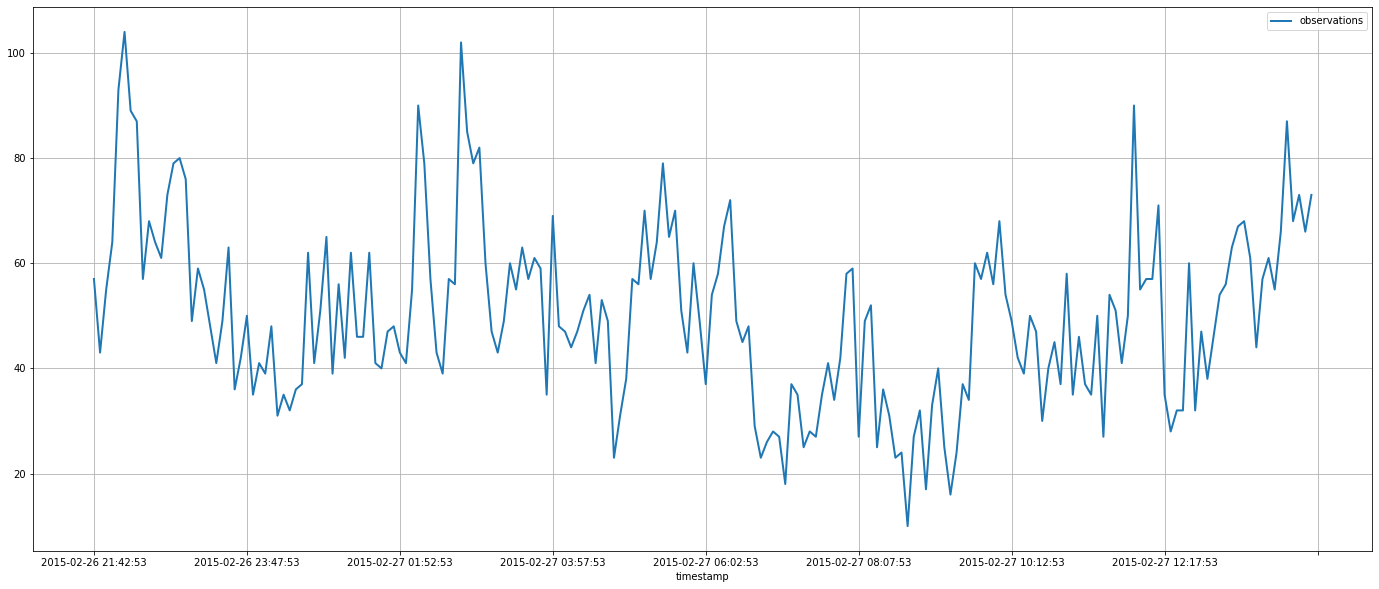

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv"
df = pd.read_csv(url, header=0, index_col=0)

df[:200].plot(figsize=(24, 10), linewidth=2)
plt.grid()
plt.legend(["observations"])
plt.show()

GluonTS 提供了 Dataset 抽象层来统一各种不同输入格式的读取。

在这里，我们使用 ListDataset 来读取在内存中以字典列表形式存储的数据。
在 GluonTS 中，任何 Dataset 对象都是一个将字符串键值映射到任意值的字典的迭代器。 

将数据截断到 2015 年 4 月 5 日为止，用于训练模型。在 4 月 5 日之后的数据将被用于测试训练好的模型。



In [4]:
from gluonts.dataset.common import ListDataset
training_data = ListDataset(
    [{"start": df.index[0], "target": df.value[:"2015-04-05 00:00:00"]}],
    freq = "5min"
)

数据集在手，现在就可以使用刚才建立的 Estimator 的 train 接口来训练模型。
当训练完成之后，你就会得到一个可以进行预测的 Predictor 对象。

In [5]:
predictor = estimator.train(training_data=training_data)

100%|██████████| 50/50 [00:22<00:00,  2.25it/s, epoch=10/10, avg_epoch_loss=3.95]


## 模型评估

现在你可以使用 Predictor 来画出模型对于在训练数据之后的时间段的一些预测。绘出模型给出的预测有助于我们对这个模型的预测质量有一个定性的感受。 

现在，基于同样的数据集，在之前用于训练的时间段之后的时间段取出若干组测试数据。

In [6]:
test_data = ListDataset(
    [
        {"start": df.index[0], "target": df.value[:"2015-04-10 03:00:00"]},
        {"start": df.index[0], "target": df.value[:"2015-04-15 18:00:00"]},
        {"start": df.index[0], "target": df.value[:"2015-04-20 12:00:00"]}
    ],
    freq = "5min"
)

如下图所示，模型给出的是概率预测，这是很重要的一点，因为概率预测提供了对于模型置信度的估计，并且可以使得下游基于此预测的决策能够考虑到预测的不确定性。

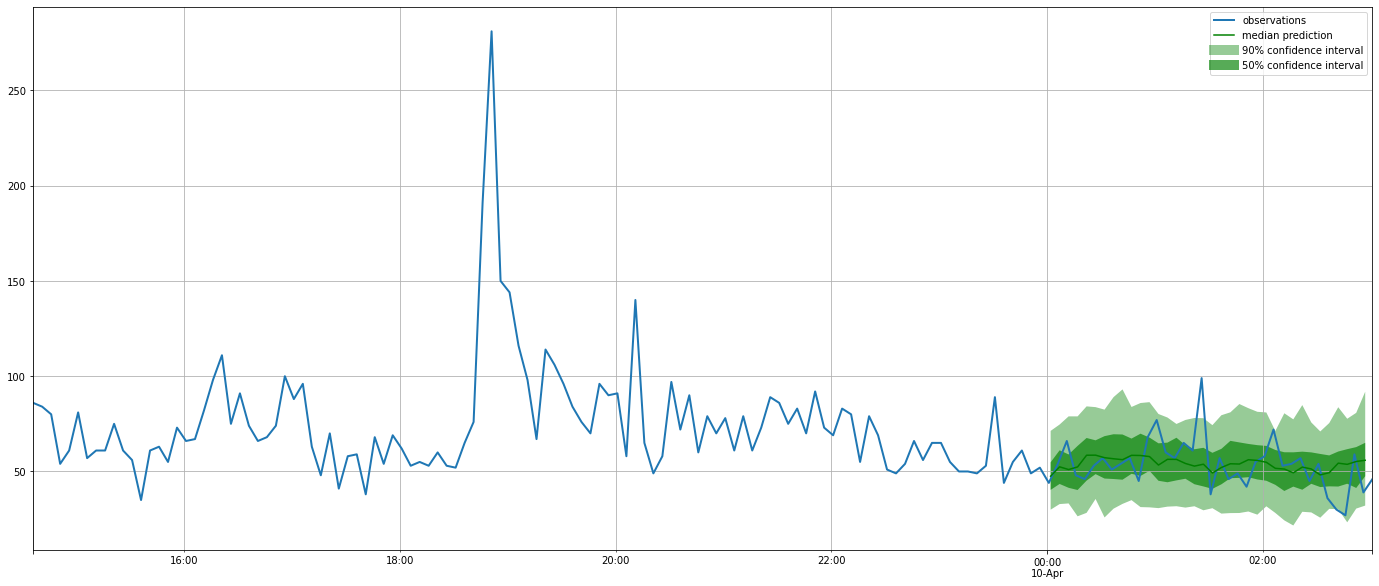

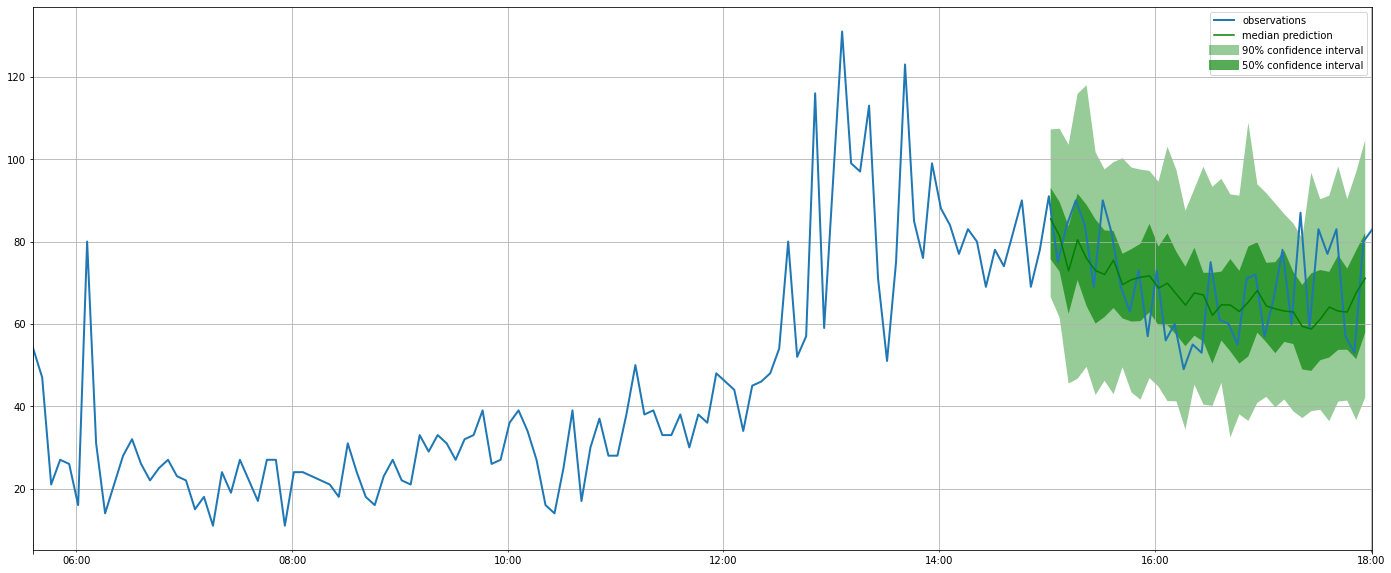

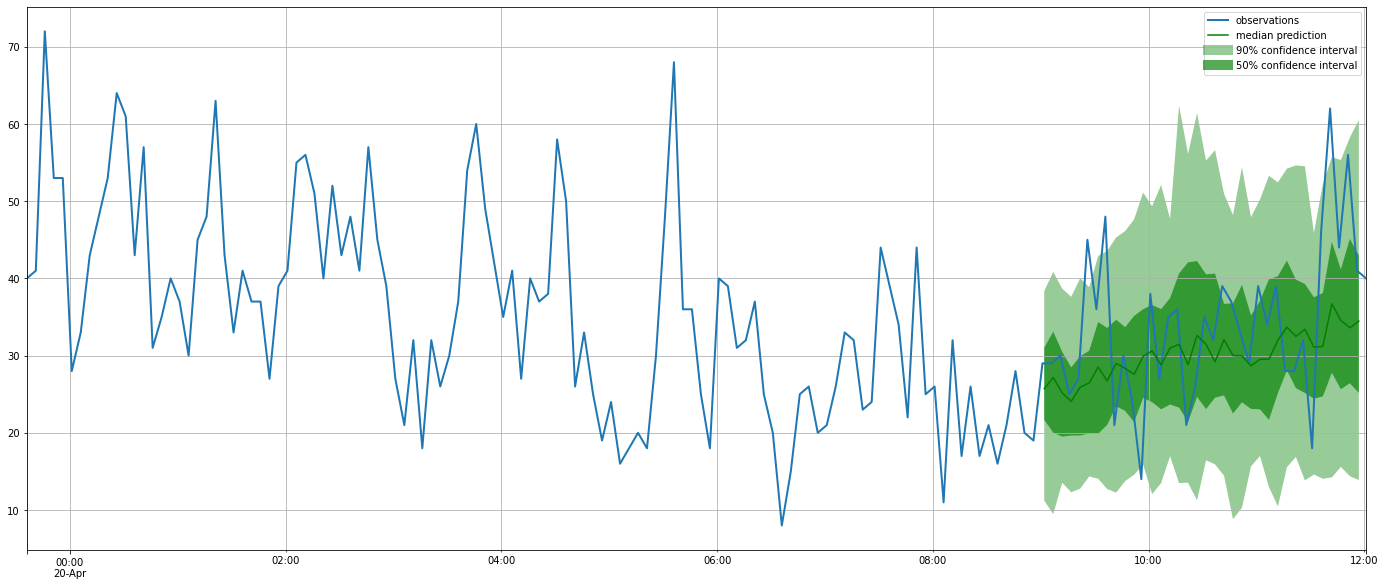

In [7]:
from itertools import islice
from gluonts.evaluation.backtest import make_evaluation_predictions

def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(24, 10), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_samples=100)
forecasts = list(forecast_it)
tss = list(ts_it)
plot_forecasts(tss, forecasts, past_length=150, num_plots=3)

看起来预测还算准确！

现在我们可以定量地使用一系列指标来定量评估预测的质量。GluonTS 提供了用于评估模型的 Evaluator 模块。

Evaluator 模块提供了常用的误差指标，例如 MSE、MASE、symmetric MAPE、RMSE 以及（加权）量化误差等。

In [8]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.5], seasonality=2016)
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))
agg_metrics

Running evaluation: 100%|██████████| 3/3 [00:00<00:00, 64.48it/s]


{'MSE': 133.69523111979166,
 'abs_error': 969.3833923339844,
 'abs_target_sum': 5658.0,
 'abs_target_mean': 52.38888888888889,
 'seasonal_error': 18.833625618877182,
 'MASE': 0.4763316433187343,
 'MAPE': 0.18820048703087702,
 'sMAPE': 0.1839077914202655,
 'MSIS': 3.634423904536353,
 'QuantileLoss[0.5]': 969.3834171295166,
 'Coverage[0.5]': 0.4444444444444444,
 'RMSE': 11.562665398591783,
 'NRMSE': 0.22070835331352287,
 'ND': 0.17132969111593926,
 'wQuantileLoss[0.5]': 0.1713296954983239,
 'mean_absolute_QuantileLoss': 969.3834171295166,
 'mean_wQuantileLoss': 0.1713296954983239,
 'MAE_Coverage': 0.05555555555555558,
 'OWA': nan}

你可以将以上指标与其他模型或是你的预测应用的业务要求作比较。
例如，我们可以用 Seasonal Naive Method 进行预测，然后与以上结果比较。

Seasonal Naive Method 假设数据会有一个固定的周期性（本例中，2016 个数据点是一周，作为一个周期），并通过基于周期性来复制之前观察到的训练数据进行预测。


In [9]:
from gluonts.model.seasonal_naive import SeasonalNaivePredictor

seasonal_predictor_1W = SeasonalNaivePredictor(freq="5min", prediction_length=36, season_length=2016)

forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=seasonal_predictor_1W, num_samples=100)
forecasts = list(forecast_it)
tss = list(ts_it)

agg_metrics_seasonal, item_metrics_seasonal = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

df_metrics = pd.DataFrame.join(
    pd.DataFrame.from_dict(agg_metrics, orient='index').rename(columns={0: "DeepAR"}),
    pd.DataFrame.from_dict(agg_metrics_seasonal, orient='index').rename(columns={0: "Seasonal naive"})
)

df_metrics.loc[["MASE", "sMAPE", "RMSE"]]

Running evaluation: 100%|██████████| 3/3 [00:00<00:00, 79.67it/s]


,DeepAR,Seasonal naive
MASE,0.476332,1.024993
sMAPE,0.183908,0.341459
RMSE,11.562665,28.481475
